# Lab 2

## Prelab

SAW enumeration up to 5 steps    N  count        R2
0  1      4  1.000000
1  2     12  2.666667
2  3     36  4.555556
3  4    100  7.040000
4  5    284  9.563380
Fit using N=1..5: R2 = a * N^(2*nu) with a = 0.9997, 2*nu = 1.4012 => nu = 0.7006
Fit using N=2..5: a = 0.9988, 2*nu = 1.4019 => nu = 0.7009


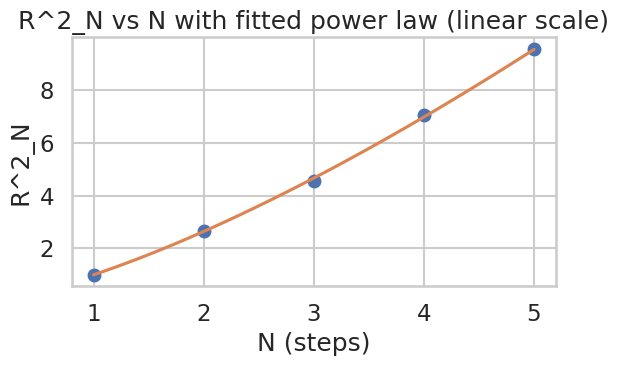

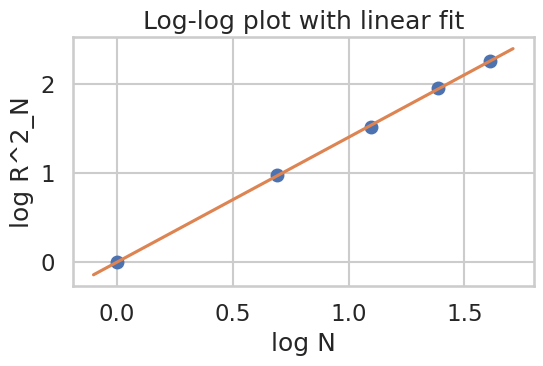

In [7]:
# Generating all self-avoiding walks on the square lattice up to 5 steps,
# computing R_N^2 for N=1..5, and fitting R_N^2 = a * N^(2*nu).
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

moves = [(1,0),(-1,0),(0,1),(0,-1)]

def generate_saws(n):
    # returns list of endpoint coordinates for all SAWs of length n starting at (0,0)
    walks = [ [(0,0)] ]  # list of lists of coordinates
    for step in range(n):
        new_walks = []
        for w in walks:
            head = w[-1]
            for dx,dy in moves:
                nxt = (head[0]+dx, head[1]+dy)
                if nxt not in w:  # self-avoiding constraint
                    new_walks.append(w + [nxt])
        walks = new_walks
    return walks

results = []
for N in range(1,6):
    walks = generate_saws(N)
    count = len(walks)
    endpoints = [w[-1] for w in walks]
    rsq = [x*x + y*y for x,y in endpoints]
    R2 = float(np.mean(rsq)) if count>0 else np.nan
    results.append({"N":N, "count":count, "R2":R2})

df = pd.DataFrame(results)
print("SAW enumeration up to 5 steps", df)

# Fit log(R2) = log(a) + (2*nu) * log(N). We'll fit using N=1..5 (all points)
Ns = df["N"].values
R2s = df["R2"].values
logN = np.log(Ns)
logR2 = np.log(R2s)

# simple linear regression
A = np.vstack([logN, np.ones_like(logN)]).T
slope, intercept = np.linalg.lstsq(A, logR2, rcond=None)[0]
two_nu = slope
nu = two_nu / 2.0
a = math.exp(intercept)

# also do fit excluding N=1 to see sensitivity
mask = Ns>=2
A2 = np.vstack([np.log(Ns[mask]), np.ones_like(Ns[mask])]).T
slope2, intercept2 = np.linalg.lstsq(A2, np.log(R2s[mask]), rcond=None)[0]
nu2 = slope2/2.0
a2 = math.exp(intercept2)

print(f"Fit using N=1..5: R2 = a * N^(2*nu) with a = {a:.4f}, 2*nu = {two_nu:.4f} => nu = {nu:.4f}")
print(f"Fit using N=2..5: a = {a2:.4f}, 2*nu = {slope2:.4f} => nu = {nu2:.4f}")

# plot R2 vs N and log-log with fit line
plt.figure(figsize=(6,4))
plt.plot(Ns, R2s, marker='o', linestyle='none')
Nplot = np.linspace(1,5,100)
plt.plot(Nplot, a * (Nplot**(2*nu)), linestyle='-')
plt.xlabel('N (steps)')
plt.ylabel('R^2_N')
plt.title('R^2_N vs N with fitted power law (linear scale)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(logN, logR2, marker='o', linestyle='none')
# plot fit line from first fit
xline = np.linspace(min(logN)-0.1, max(logN)+0.1, 100)
plt.plot(xline, intercept + two_nu * xline, linestyle='-')
plt.xlabel('log N')
plt.ylabel('log R^2_N')
plt.title('Log-log plot with linear fit')
plt.tight_layout()
plt.show()


## Lab 2
### Exercise A


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import numba

def simulate_ideal_polymer(N_max, M, dimension=2):
    # Initialize arrays
    R2_P = np.zeros(N_max)  # Mean squared end-to-end distance
    R2_g = np.zeros(N_max)  # Mean squared radius of gyration

    if dimension == 2:
        allowed_moves = [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]
        pos_0 = np.array([0,0])
        pos_1 = np.array([1,0])
    else:  # 3D
        allowed_moves = [np.array([1,0,0]), np.array([-1,0,0]), np.array([0,1,0]),
                        np.array([0,-1,0]), np.array([0,0,1]), np.array([0,0,-1])]
        pos_0 = np.array([0,0,0])
        pos_1 = np.array([1,0,0])

    for _ in range(M):
        path = [pos_0.copy(), pos_1.copy()]
        current_pos = pos_1.copy()

        # Generate random walk
        for step in range(2, N_max):
            move = allowed_moves[np.random.randint(len(allowed_moves))]
            current_pos = current_pos + move
            path.append(current_pos.copy())

        # Calculate R_P^2 and R_g^2 for each chain length
        for n in range(2, N_max):
            # End-to-end distance squared
            end_to_end = path[n] - path[0]
            R2_P[n] += np.sum(end_to_end**2)

            # Radius of gyration squared
            positions = np.array(path[:n+1])
            center_of_mass = np.mean(positions, axis=0)
            squared_distances = np.sum((positions - center_of_mass)**2, axis=1)
            R2_g[n] += np.mean(squared_distances)

    # Average over all realizations
    R2_P /= M
    R2_g /= M

    # Convert to R_P and R_g (square roots)
    R_P = np.sqrt(R2_P)
    R_g = np.sqrt(R2_g)

    return R_P, R_g

In [9]:
from scipy.stats import linregress
N_max = 100
M = 1000
R_P_2D, R_g_2D = simulate_ideal_polymer(N_max, M, dimension=2)
R_P_3D, R_g_3D = simulate_ideal_polymer(N_max, M, dimension=3)
N = np.arange(N_max)
logN = np.log(N[2:])  # Exclude N=0 for log scale
logR_P_2D = np.log(R_P_2D[2:])
logR_g_2D = np.log(R_g_2D[2:])
logR_P_3D = np.log(R_P_3D[2:])
logR_g_3D = np.log(R_g_3D[2:])
nu_P_2D = np.polyfit(logN, logR_P_2D, 1)[0]
nu_g_2D = np.polyfit(logN, logR_g_2D, 1)[0]
nu_P_3D = np.polyfit(logN, logR_P_3D, 1)[0]
nu_g_3D = np.polyfit(logN, logR_g_3D, 1)[0]

# Fit for R_P in 2D
slope, intercept, r_value, p_value, std_err = linregress(logN, np.log(R_P_2D[2:]))
nu_P_2D = slope
error_nu_P_2D = std_err

# Fit for R_g in 2D
slope, intercept, r_value, p_value, std_err = linregress(logN, np.log(R_g_2D[2:]))
nu_g_2D = slope
error_nu_g_2D = std_err

# Fit for R_P in 3D
slope, intercept, r_value, p_value, std_err = linregress(logN, np.log(R_P_3D[2:]))
nu_P_3D = slope
error_nu_P_3D = std_err

# Fit for R_g in 3D
slope, intercept, r_value, p_value, std_err = linregress(logN, np.log(R_g_3D[2:]))
nu_g_3D = slope
error_nu_g_3D = std_err



print(f"nu_P_2D = {nu_P_2D:.4f} ± {error_nu_P_2D:.4f}")
print(f"nu_g_2D = {nu_g_2D:.4f} ± {error_nu_g_2D:.4f}")
print(f"nu_P_3D = {nu_P_3D:.4f} ± {error_nu_P_3D:.4f}")
print(f"nu_g_3D = {nu_g_3D:.4f} ± {error_nu_g_3D:.4f}")


nu_P_2D = 0.4931 ± 0.0017
nu_g_2D = 0.4730 ± 0.0008
nu_P_3D = 0.4974 ± 0.0006
nu_g_3D = 0.4773 ± 0.0013


<>:29: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2516813190.py:29: SyntaxWarning: invalid escape sequence '\l'
  axes[0].set_ylabel('$\langle R \\rangle $')


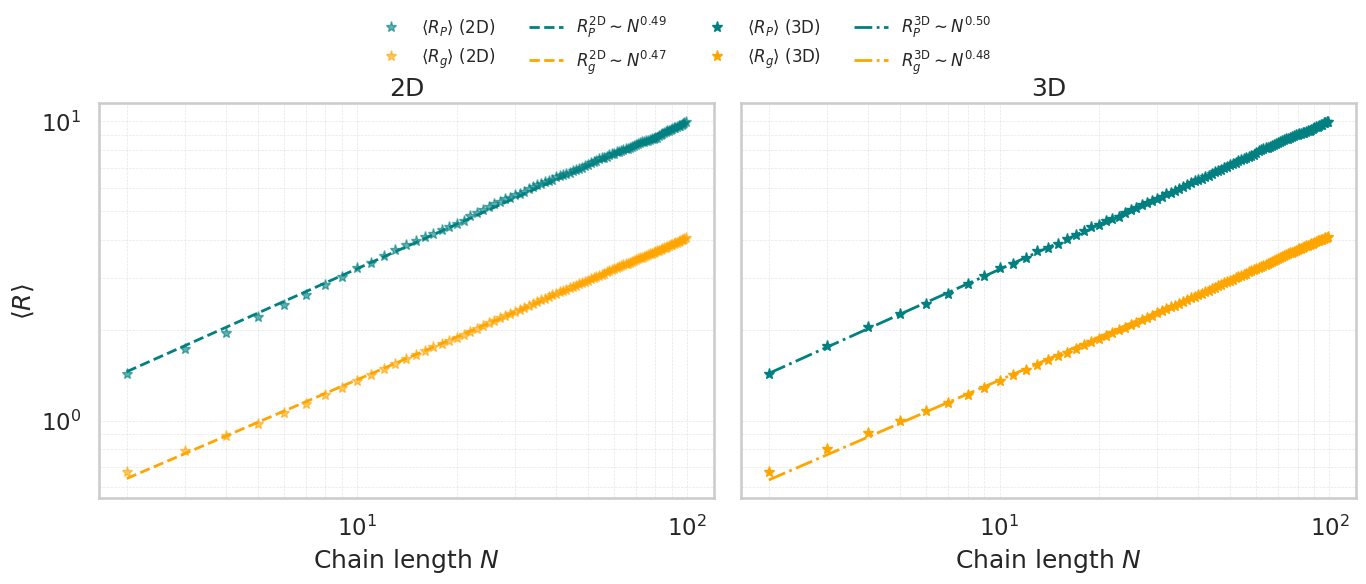

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

sns.set(style='whitegrid', context='talk', palette='deep')

logN = np.log(N[2:])

# Do linear regressions
slope_P_2D, intercept_P_2D, _, _, _ = linregress(logN, np.log(R_P_2D[2:]))
slope_g_2D, intercept_g_2D, _, _, _ = linregress(logN, np.log(R_g_2D[2:]))
slope_P_3D, intercept_P_3D, _, _, _ = linregress(logN, np.log(R_P_3D[2:]))
slope_g_3D, intercept_g_3D, _, _, _ = linregress(logN, np.log(R_g_3D[2:]))

# Figure
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# Left part (2D)
axes[0].plot(N[2:], R_P_2D[2:], '*', color='teal', alpha=0.6, markersize=8, linestyle='', label=r'$\langle R_P \rangle$ (2D)')
axes[0].plot(N[2:], R_g_2D[2:], '*', color='orange', alpha=0.6, markersize=8, linestyle='', label=r'$\langle R_g \rangle$ (2D)')
axes[0].plot(N[2:], np.exp(intercept_P_2D) * N[2:]**slope_P_2D, '--', color='teal', linewidth=2,
             label=fr'$R_P^{{\mathrm{{2D}}}} \sim N^{{{slope_P_2D:.2f}}}$')
axes[0].plot(N[2:], np.exp(intercept_g_2D) * N[2:]**slope_g_2D, '--', color='orange', linewidth=2,
             label=fr'$R_g^{{\mathrm{{2D}}}} \sim N^{{{slope_g_2D:.2f}}}$')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Chain length $N$')
axes[0].set_ylabel('$\langle R \\rangle $')
axes[0].set_title('2D')
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
axes[0].minorticks_on()

# Right part (3D)
axes[1].plot(N[2:], R_P_3D[2:], '*', color='teal', markersize=8, linestyle='', label=r'$\langle R_P \rangle$ (3D)')
axes[1].plot(N[2:], R_g_3D[2:], '*', color='orange', markersize=8, linestyle='', label=r'$\langle R_g \rangle$ (3D)')
axes[1].plot(N[2:], np.exp(intercept_P_3D) * N[2:]**slope_P_3D, '-.', color='teal', linewidth=2,
             label=fr'$R_P^{{\mathrm{{3D}}}} \sim N^{{{slope_P_3D:.2f}}}$')
axes[1].plot(N[2:], np.exp(intercept_g_3D) * N[2:]**slope_g_3D, '-.', color='orange', linewidth=2,
             label=fr'$R_g^{{\mathrm{{3D}}}} \sim N^{{{slope_g_3D:.2f}}}$')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Chain length $N$')
axes[1].set_title('3D')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
axes[1].minorticks_on()

# Legend
handles0, labels0 = axes[0].get_legend_handles_labels()
handles1, labels1 = axes[1].get_legend_handles_labels()
handles = handles0 + handles1
labels = labels0 + labels1
fig.legend(handles, labels, loc='upper center', ncol=4, frameon=False, fontsize=12)

plt.tight_layout(rect=[0,0,1,0.92])
plt.show()


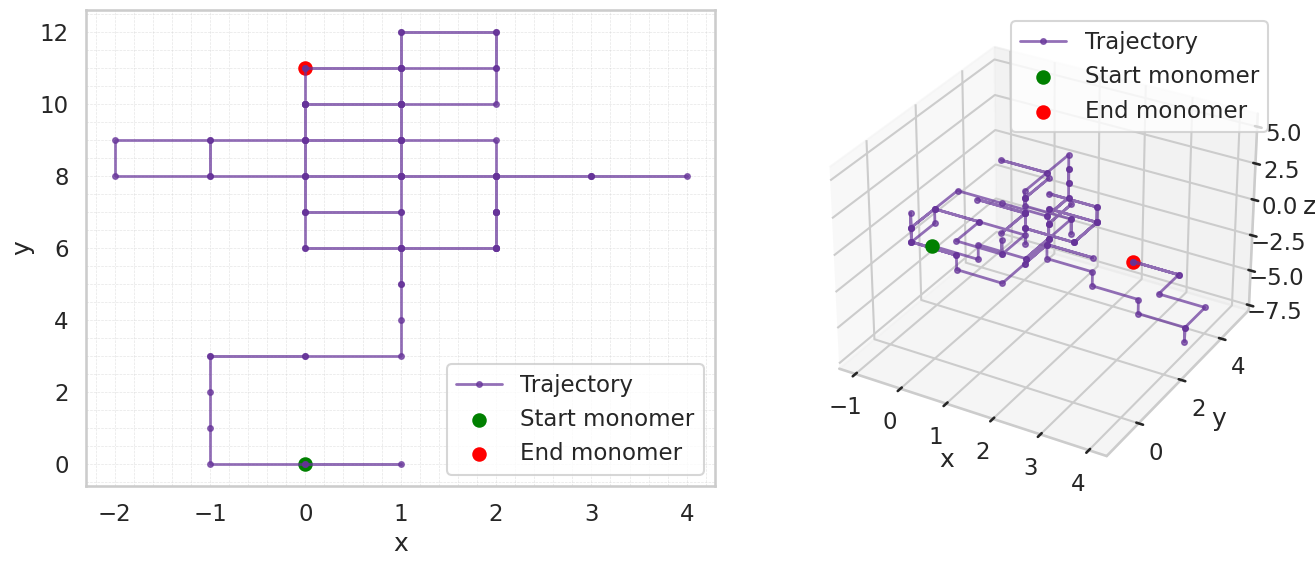

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='talk', palette='deep')

# Function to generate only one trajectory
def generate_one_ideal_polymer(N_max=100, dimension=2):
    if dimension == 2:
        allowed_moves = [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]
        pos_0 = np.array([0,0])
        pos_1 = np.array([1,0])
    else:
        allowed_moves = [np.array([1,0,0]), np.array([-1,0,0]),
                         np.array([0,1,0]), np.array([0,-1,0]),
                         np.array([0,0,1]), np.array([0,0,-1])]
        pos_0 = np.array([0,0,0])
        pos_1 = np.array([1,0,0])

    path = [pos_0.copy(), pos_1.copy()]
    current_pos = pos_1.copy()

    for _ in range(2, N_max):
        move = allowed_moves[np.random.randint(len(allowed_moves))]
        current_pos = current_pos + move
        path.append(current_pos.copy())

    return np.array(path)

# Generate one trajectory in 2D and 3D
path_2D = generate_one_ideal_polymer(N_max=100, dimension=2)
path_3D = generate_one_ideal_polymer(N_max=100, dimension=3)

# Generate figure
fig = plt.figure(figsize=(14,6))

# 2D (Left)
ax1 = fig.add_subplot(1,2,1)
ax1.plot(path_2D[:,0], path_2D[:,1], '-o', color='rebeccapurple', markersize=4, linewidth=2, alpha=0.7, label='Trajectory')
ax1.scatter(path_2D[0,0], path_2D[0,1], color='green', s=80, label='Start monomer')
ax1.scatter(path_2D[-1,0], path_2D[-1,1], color='red', s=80, label='End monomer')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.minorticks_on()
ax1.legend()

# 3D (right)
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot(path_3D[:,0], path_3D[:,1], path_3D[:,2], '-o', color='rebeccapurple', markersize=4, linewidth=2, alpha=0.7, label='Trajectory')
ax2.scatter(path_3D[0,0], path_3D[0,1], path_3D[0,2], color='green', s=80, label='Start monomer')
ax2.scatter(path_3D[-1,0], path_3D[-1,1], path_3D[-1,2], color='red', s=80, label='End monomer')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.legend()

plt.tight_layout()
plt.show()


## Exercise B
### Exercise 1.

In [12]:
def simulate_excluded_volume_polymer(N_max, M, dimension=2):
    R2_P = np.zeros(N_max)
    R2_g = np.zeros(N_max)
    counts = np.zeros(N_max)   #

    # Allowed moves
    if dimension == 2:
        allowed_moves = [np.array([1,0]), np.array([-1,0]),
                         np.array([0,1]), np.array([0,-1])]
        pos_0 = np.array([0,0])
    else:
        allowed_moves = [np.array([1,0,0]), np.array([-1,0,0]),
                         np.array([0,1,0]), np.array([0,-1,0]),
                         np.array([0,0,1]), np.array([0,0,-1])]
        pos_0 = np.array([0,0,0])

    for _ in range(M):
        path = [pos_0.copy()]
        occupied = {tuple(pos_0)}

        # Generate SAW (Self-Avoiding Walks)
        for step in range(1, N_max):
            current = path[-1]
            move_options = []
            for mv in allowed_moves:
                nxt = current + mv
                if tuple(nxt) not in occupied:
                    move_options.append(nxt)

            if not move_options:
                break  # chain terminated early

            next_pos = move_options[np.random.randint(len(move_options))]
            path.append(next_pos.copy())
            occupied.add(tuple(next_pos))

        actual_length = len(path)

        # Compute properties for all n < actual_length
        for n in range(1, actual_length):
            counts[n] += 1

            # End-to-end R^2
            R = path[n] - path[0]
            R2_P[n] += np.dot(R, R)

            # Gyration radius
            arr = np.array(path[:n+1])
            Rcm = arr.mean(axis=0)
            Rg2 = ((arr - Rcm)**2).sum(axis=1).mean()
            R2_g[n] += Rg2

    # Normalize only by chains that reached each n
    mask = counts > 0
    R2_P[mask] /= counts[mask]
    R2_g[mask] /= counts[mask]

    return R2_P, R2_g


### Exercise 2.

In [13]:
def rosenbluth(N_max, M, dimension=2):

    # Allowed moves and origin
    if dimension == 2:
        allowed_moves = [np.array([1,0]), np.array([-1,0]),
                         np.array([0,1]), np.array([0,-1])]
        pos_0 = np.array([0,0])
    else:
        allowed_moves = [np.array([1,0,0]), np.array([-1,0,0]),
                         np.array([0,1,0]), np.array([0,-1,0]),
                         np.array([0,0,1]), np.array([0,0,-1])]
        pos_0 = np.array([0,0,0])

    # Accumulators for weighted averages
    W = np.zeros(N_max)        # total statistical weight
    R2_P = np.zeros(N_max)     # weighted ⟨R^2⟩
    R2_g = np.zeros(N_max)     # weighted ⟨Rg^2⟩

    for _ in range(M):
        path = [pos_0.copy()]
        occupied = {tuple(pos_0)}

        w = 1.0                # Rosenbluth total chain weight
        w_step = []            # store mk for each step

        # Grow polymer
        for i in range(1, N_max):
            current = path[-1]
            move_options = []

            # Count available next steps
            for mv in allowed_moves:
                nxt = current + mv
                if tuple(nxt) not in occupied:
                    move_options.append(nxt)

            mk = len(move_options)  # number of valid moves

            if mk == 0:
                break  # chain terminates early

            # Update Rosenbluth weight
            w *= mk
            w_step.append(mk)

            # Choose uniformly among available positions
            nxt = move_options[np.random.randint(mk)]
            path.append(nxt.copy())
            occupied.add(tuple(nxt))

            # ---- Compute R² and Rg² up to this point ----
            R = path[-1] - path[0]
            R2 = np.dot(R, R)

            # Radius of gyration
            arr = np.array(path)
            Rcm = arr.mean(axis=0)
            Rg2 = ((arr - Rcm) ** 2).sum(axis=1).mean()

            # Accumulate weighted averages
            W[i] += w
            R2_P[i] += w * R2
            R2_g[i] += w * Rg2

    # Normalize weighted averages
    nonzero = W > 0
    R2_P[nonzero] /= W[nonzero]
    R2_g[nonzero] /= W[nonzero]

    return R2_P, R2_g


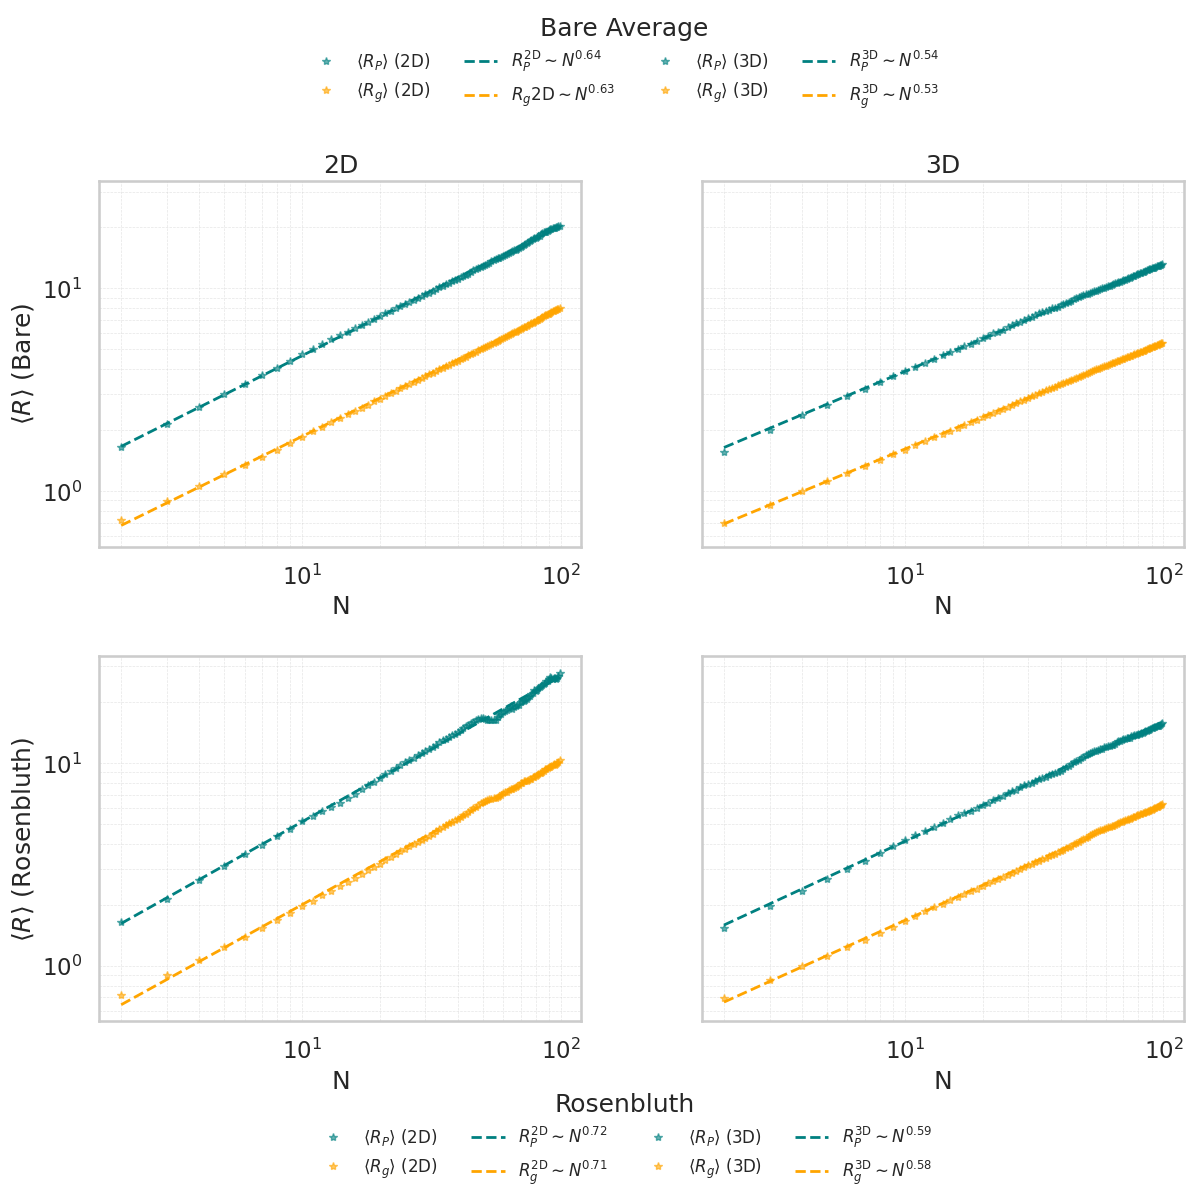

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

sns.set(style='whitegrid', context='talk', palette='deep')

N_max = 100
N = np.arange(N_max)
M = 1000
logN = np.log(N[2:])

# Use results
# Bare average
R2_P_bare_2D, R2_g_bare_2D = simulate_excluded_volume_polymer(N_max, M, dimension=2)
R2_P_bare_3D, R2_g_bare_3D = simulate_excluded_volume_polymer(N_max, M, dimension=3)
R_P_bare_2D = np.sqrt(R2_P_bare_2D)
R_g_bare_2D = np.sqrt(R2_g_bare_2D)
R_P_bare_3D = np.sqrt(R2_P_bare_3D)
R_g_bare_3D = np.sqrt(R2_g_bare_3D)

# Rosenbluth
R2_P_ros_2D, R2_g_ros_2D = rosenbluth(N_max, M, dimension=2)
R2_P_ros_3D, R2_g_ros_3D = rosenbluth(N_max, M, dimension=3)
R_P_ros_2D = np.sqrt(R2_P_ros_2D)
R_g_ros_2D = np.sqrt(R2_g_ros_2D)
R_P_ros_3D = np.sqrt(R2_P_ros_3D)
R_g_ros_3D = np.sqrt(R2_g_ros_3D)

# Do li9near regression
def compute_fit(R_P, R_g):
    slope_P, intercept_P, _, _, _ = linregress(logN, np.log(R_P[2:]))
    slope_g, intercept_g, _, _, _ = linregress(logN, np.log(R_g[2:]))
    return slope_P, intercept_P, slope_g, intercept_g

slope_P_bare_2D, intercept_P_bare_2D, slope_g_bare_2D, intercept_g_bare_2D = compute_fit(R_P_bare_2D, R_g_bare_2D)
slope_P_bare_3D, intercept_P_bare_3D, slope_g_bare_3D, intercept_g_bare_3D = compute_fit(R_P_bare_3D, R_g_bare_3D)
slope_P_ros_2D, intercept_P_ros_2D, slope_g_ros_2D, intercept_g_ros_2D = compute_fit(R_P_ros_2D, R_g_ros_2D)
slope_P_ros_3D, intercept_P_ros_3D, slope_g_ros_3D, intercept_g_ros_3D = compute_fit(R_P_ros_3D, R_g_ros_3D)

# Generate figure
fig, axes = plt.subplots(2, 2, figsize=(14,12), sharey=True)

# Bare 2D
ax = axes[0,0]
ax.plot(N[2:], R_P_bare_2D[2:], '*', color='teal', alpha=0.6, markersize=6, linestyle='', label=r'$\langle R_P \rangle$ (2D)')
ax.plot(N[2:], R_g_bare_2D[2:], '*', color='orange', alpha=0.6, markersize=6, linestyle='', label=r'$\langle R_g \rangle$ (2D)')
ax.plot(N[2:], np.exp(intercept_P_bare_2D)*N[2:]**slope_P_bare_2D, '--', color='teal', linewidth=2,
        label=fr'$R_P^{{\mathrm{{2D}}}} \sim N^{{{slope_P_bare_2D:.2f}}}$')
ax.plot(N[2:], np.exp(intercept_g_bare_2D)*N[2:]**slope_g_bare_2D, '--', color='orange', linewidth=2,
        label=fr'$R_g{{\mathrm{{2D}}}} \sim N^{{{slope_g_bare_2D:.2f}}}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('N')
ax.set_ylabel(r'$\langle R \rangle$ (Bare)')
ax.set_title('2D')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax.minorticks_on()

# Bare 3D
ax = axes[0,1]
ax.plot(N[2:], R_P_bare_3D[2:], '*', color='teal', alpha=0.6, markersize=6, linestyle='', label=r'$\langle R_P \rangle$ (3D)')
ax.plot(N[2:], R_g_bare_3D[2:], '*', color='orange', alpha=0.6, markersize=6, linestyle='', label=r'$\langle R_g \rangle$ (3D)')
ax.plot(N[2:], np.exp(intercept_P_bare_3D)*N[2:]**slope_P_bare_3D, '--', color='teal', linewidth=2,
        label=fr'$R_P^{{\mathrm{{3D}}}} \sim N^{{{slope_P_bare_3D:.2f}}}$')
ax.plot(N[2:], np.exp(intercept_g_bare_3D)*N[2:]**slope_g_bare_3D, '--', color='orange', linewidth=2,
        label=fr'$R_g^{{\mathrm{{3D}}}} \sim N^{{{slope_g_bare_3D:.2f}}}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('N')
ax.set_title('3D')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax.minorticks_on()

# Rosenbluth 2D
ax = axes[1,0]
ax.plot(N[2:], R_P_ros_2D[2:], '*', color='teal', alpha=0.6, markersize=6, linestyle='', label=r'$\langle R_P \rangle$ (2D)')
ax.plot(N[2:], R_g_ros_2D[2:], '*', color='orange', alpha=0.6, markersize=6, linestyle='', label=r'$\langle R_g \rangle$ (2D)')
ax.plot(N[2:], np.exp(intercept_P_ros_2D)*N[2:]**slope_P_ros_2D, '--', color='teal', linewidth=2,
        label=fr'$R_P^{{\mathrm{{2D}}}} \sim N^{{{slope_P_ros_2D:.2f}}}$')
ax.plot(N[2:], np.exp(intercept_g_ros_2D)*N[2:]**slope_g_ros_2D, '--', color='orange', linewidth=2,
        label=fr'$R_g^{{\mathrm{{2D}}}} \sim N^{{{slope_g_ros_2D:.2f}}}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('N')
ax.set_ylabel(r'$\langle R \rangle$ (Rosenbluth)')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax.minorticks_on()

# Rosenbluth 3D
ax = axes[1,1]
ax.plot(N[2:], R_P_ros_3D[2:], '*', color='teal', alpha=0.6, markersize=6, linestyle='', label=r'$\langle R_P \rangle$ (3D)')
ax.plot(N[2:], R_g_ros_3D[2:], '*', color='orange', alpha=0.6, markersize=6, linestyle='', label=r'$\langle R_g \rangle$ (3D)')
ax.plot(N[2:], np.exp(intercept_P_ros_3D)*N[2:]**slope_P_ros_3D, '--', color='teal', linewidth=2,
        label=fr'$R_P^{{\mathrm{{3D}}}} \sim N^{{{slope_P_ros_3D:.2f}}}$')
ax.plot(N[2:], np.exp(intercept_g_ros_3D)*N[2:]**slope_g_ros_3D, '--', color='orange', linewidth=2,
        label=fr'$R_g^{{\mathrm{{3D}}}} \sim N^{{{slope_g_ros_3D:.2f}}}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('N')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax.minorticks_on()


# Legends
fig.subplots_adjust(top=0.85, bottom=0.15, hspace=0.3, wspace=0.25)

# Bare average: legend on top
handles_bare_2D, labels_bare_2D = axes[0,0].get_legend_handles_labels()
handles_bare_3D, labels_bare_3D = axes[0,1].get_legend_handles_labels()
handles_bare = handles_bare_2D + handles_bare_3D
labels_bare = labels_bare_2D + labels_bare_3D
fig.legend(handles_bare, labels_bare, loc='upper center',
           bbox_to_anchor=(0.5, 1.0), ncol=4, frameon=False,
           fontsize=12, title='Bare Average')

# Rosenbluth: legend below
handles_ros_2D, labels_ros_2D = axes[1,0].get_legend_handles_labels()
handles_ros_3D, labels_ros_3D = axes[1,1].get_legend_handles_labels()
handles_ros = handles_ros_2D + handles_ros_3D
labels_ros = labels_ros_2D + labels_ros_3D
fig.legend(handles_ros, labels_ros, loc='lower center',
           bbox_to_anchor=(0.5, 0.0), ncol=4, frameon=False,
           fontsize=12, title='Rosenbluth')

# Show figure
plt.show()


In [15]:
from scipy.stats import linregress

# Errors for nu

# Bare 2D
slope_P_bare_2D, intercept_P_bare_2D, r_value, p_value, slope_err_P_bare_2D = linregress(logN, np.log(R_P_bare_2D[2:]))
slope_g_bare_2D, intercept_g_bare_2D, r_value, p_value, slope_err_g_bare_2D = linregress(logN, np.log(R_g_bare_2D[2:]))

# Bare 3D
slope_P_bare_3D, intercept_P_bare_3D, r_value, p_value, slope_err_P_bare_3D = linregress(logN, np.log(R_P_bare_3D[2:]))
slope_g_bare_3D, intercept_g_bare_3D, r_value, p_value, slope_err_g_bare_3D = linregress(logN, np.log(R_g_bare_3D[2:]))

# Rosenbluth 2D
slope_P_ros_2D, intercept_P_ros_2D, r_value, p_value, slope_err_P_ros_2D = linregress(logN, np.log(R_P_ros_2D[2:]))
slope_g_ros_2D, intercept_g_ros_2D, r_value, p_value, slope_err_g_ros_2D = linregress(logN, np.log(R_g_ros_2D[2:]))

# Rosenbluth 3D
slope_P_ros_3D, intercept_P_ros_3D, r_value, p_value, slope_err_P_ros_3D = linregress(logN, np.log(R_P_ros_3D[2:]))
slope_g_ros_3D, intercept_g_ros_3D, r_value, p_value, slope_err_g_ros_3D = linregress(logN, np.log(R_g_ros_3D[2:]))

print("Bare 2D: nu_P = {:.3f} ± {:.3f}, nu_g = {:.3f} ± {:.3f}".format(
    slope_P_bare_2D, slope_err_P_bare_2D, slope_g_bare_2D, slope_err_g_bare_2D))

print("Bare 3D: nu_P = {:.3f} ± {:.3f}, nu_g = {:.3f} ± {:.3f}".format(
    slope_P_bare_3D, slope_err_P_bare_3D, slope_g_bare_3D, slope_err_g_bare_3D))

print("Rosenbluth 2D: nu_P = {:.3f} ± {:.3f}, nu_g = {:.3f} ± {:.3f}".format(
    slope_P_ros_2D, slope_err_P_ros_2D, slope_g_ros_2D, slope_err_g_ros_2D))

print("Rosenbluth 3D: nu_P = {:.3f} ± {:.3f}, nu_g = {:.3f} ± {:.3f}".format(
    slope_P_ros_3D, slope_err_P_ros_3D, slope_g_ros_3D, slope_err_g_ros_3D))



Bare 2D: nu_P = 0.640 ± 0.001, nu_g = 0.628 ± 0.001
Bare 3D: nu_P = 0.537 ± 0.001, nu_g = 0.528 ± 0.001
Rosenbluth 2D: nu_P = 0.717 ± 0.004, nu_g = 0.706 ± 0.002
Rosenbluth 3D: nu_P = 0.591 ± 0.002, nu_g = 0.576 ± 0.001


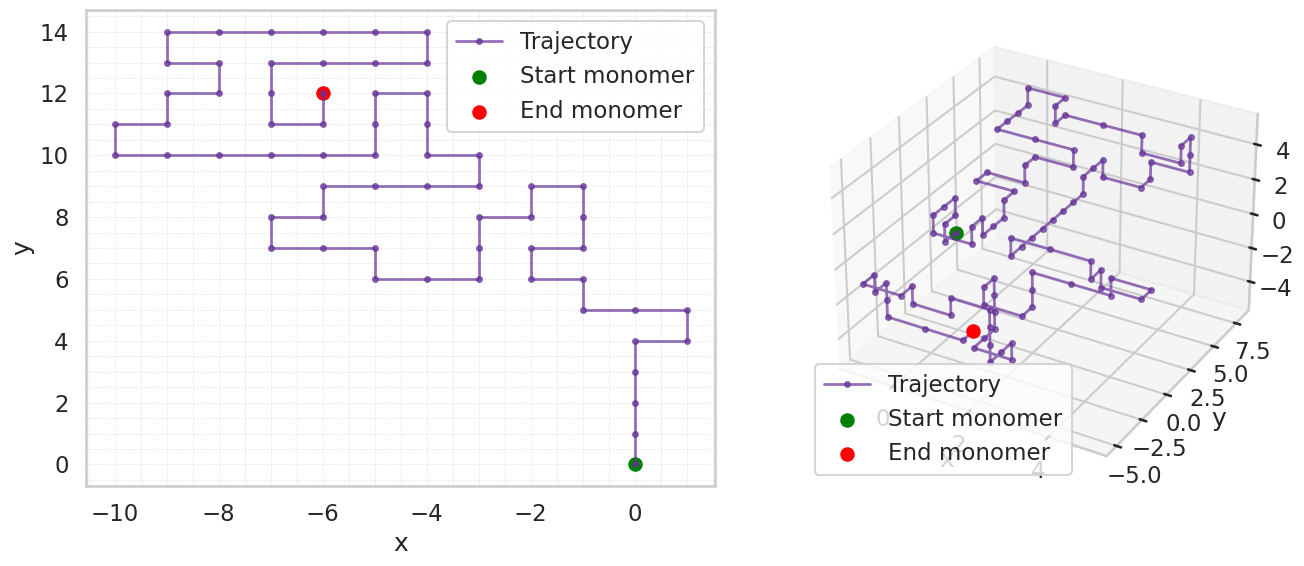

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='talk', palette='deep')

# Function to generate 1 trajectory
def generate_one_saw(N_max=100, dimension=2):
    if dimension == 2:
        allowed_moves = [np.array([1,0]), np.array([-1,0]),
                         np.array([0,1]), np.array([0,-1])]
        pos_0 = np.array([0,0])
    else:
        allowed_moves = [np.array([1,0,0]), np.array([-1,0,0]),
                         np.array([0,1,0]), np.array([0,-1,0]),
                         np.array([0,0,1]), np.array([0,0,-1])]
        pos_0 = np.array([0,0,0])

    path = [pos_0.copy()]
    visited = {tuple(pos_0)}  # Occupied positions

    current_pos = pos_0.copy()

    for _ in range(1, N_max):
        # Generate list of valid moves
        valid_moves = []
        for move in allowed_moves:
            new_pos = current_pos + move
            if tuple(new_pos) not in visited:
                valid_moves.append(new_pos)

        if not valid_moves:
            # End the growth chain if therfe is no valid moves.
            break

        # Elegir un movimiento al azar
        current_pos = valid_moves[np.random.randint(len(valid_moves))]
        path.append(current_pos.copy())
        visited.add(tuple(current_pos))

    return np.array(path)

# Generate 1 SAW trajectory in 2D and 3D
path_saw_2D = generate_one_saw(N_max=100, dimension=2)
path_saw_3D = generate_one_saw(N_max=100, dimension=3)

# Generate figure
fig = plt.figure(figsize=(14,6))

# 2D (left)
ax1 = fig.add_subplot(1,2,1)
ax1.plot(path_saw_2D[:,0], path_saw_2D[:,1], '-o', color='rebeccapurple', markersize=4, linewidth=2, alpha=0.7, label='Trajectory')
ax1.scatter(path_saw_2D[0,0], path_saw_2D[0,1], color='green', s=80, label='Start monomer')
ax1.scatter(path_saw_2D[-1,0], path_saw_2D[-1,1], color='red', s=80, label='End monomer')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.minorticks_on()
ax1.legend()


# 3D (right)
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot(path_saw_3D[:,0], path_saw_3D[:,1], path_saw_3D[:,2], '-o', color='rebeccapurple', markersize=4, linewidth=2, alpha=0.7, label='Trajectory')
ax2.scatter(path_saw_3D[0,0], path_saw_3D[0,1], path_saw_3D[0,2], color='green', s=80, label='Start monomer')
ax2.scatter(path_saw_3D[-1,0], path_saw_3D[-1,1], path_saw_3D[-1,2], color='red', s=80, label='End monomer')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.legend()


plt.tight_layout()
plt.show()
